### Importación librerias requeridas
### Obtener conexión y generar consulta ppal

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np

load_dotenv()

%run conexionDB.ipynb

# Obtener la conexión
engine = obtener_conexion()

# Consulta SQL
query = """
SELECT os.number AS No, 
       osd.priority,        
       DATE_ADD(os.created, INTERVAL -6 HOUR) as Creado,
       DATE_ADD(os.closed, INTERVAL -6 HOUR) as Cerrado
FROM ost_ticket AS os
LEFT JOIN ost_ticket__cdata AS osd ON os.ticket_id = osd.ticket_id
LEFT JOIN ost_sla AS sla ON os.sla_id = sla.id
WHERE os.topic_id BETWEEN 1 AND 26
AND DATE_ADD(os.created, INTERVAL -6 HOUR) BETWEEN '2024-11-01' AND '2024-12-01'
ORDER BY os.created
"""
# Obtener los resultados de la consulta
df = pd.read_sql(query, engine)
df

,No,priority,Creado,Cerrado
0,039823,2,2024-11-01 07:49:44,2024-11-01 08:28:56
1,039824,2,2024-11-01 08:00:15,2024-11-01 08:58:39
2,039825,2,2024-11-01 08:04:47,2024-11-01 09:01:51
3,039827,2,2024-11-01 08:30:39,2024-11-01 08:42:15
4,039828,2,2024-11-01 09:46:38,2024-11-01 10:03:18
...,...,...,...,...
349,040340,2,2024-11-29 14:46:09,2024-11-29 15:07:10
350,040344,2,2024-11-29 16:12:34,2024-11-29 16:22:53
351,040345,2,2024-11-29 16:14:02,2024-11-29 18:09:32
352,040346,2,2024-11-29 16:18:20,2024-12-02 10:56:38


### Calcular fechas dinámicamente

In [2]:
import datetime

# Obtener fecha actual
hoy = datetime.date.today()

# Obtener primer día del mes actual
primer_dia_mesactual = hoy.replace(day=1)

# Obtener último día del mes actual
ultimo_dia_mesactual = (primer_dia_mesactual.replace(month=hoy.month % 12 + 1, day=1) - datetime.timedelta(days=1))

if hoy.month == 1: # Igual a 1, estamos en enero
    primer_dia_mesanterior = hoy.replace(year=hoy.year - 1, month=12, day=1)
else: # Estamos en otro mes
    primer_dia_mesanterior = hoy.replace(month=hoy.month - 1, day=1)

#Último día del mes anterior
ultimo_dia_mesanterior = primer_dia_mesactual - datetime.timedelta(days=1)

# Convertir a texto la fecha para enviarlo en la consulta
fecha_inicio = str(primer_dia_mesanterior)
fecha_fin = str(ultimo_dia_mesanterior)

print(f"Fecha de inicio (primer día mes anterior): {fecha_inicio}")
print(f"Fecha de fin (último día mes anterior): {fecha_fin}")

Fecha de inicio (primer día mes anterior): 2024-11-01
Fecha de fin (último día mes anterior): 2024-11-30


### Ajustar el código para que la consulta SQL ejecute las fechas de forma dinámica

### Pasar los parámetros a la consulta

In [3]:
# Consulta SQL
query = f"""
SELECT os.number AS No, 
       osd.priority,        
       DATE_ADD(os.created, INTERVAL -6 HOUR) as Creado,
       DATE_ADD(os.closed, INTERVAL -6 HOUR) as Cerrado
FROM ost_ticket AS os
LEFT JOIN ost_ticket__cdata AS osd ON os.ticket_id = osd.ticket_id
LEFT JOIN ost_sla AS sla ON os.sla_id = sla.id
WHERE os.topic_id BETWEEN 1 AND 26
AND DATE_ADD(os.created, INTERVAL -6 HOUR) BETWEEN '{fecha_inicio}' AND '{fecha_fin}'
ORDER BY os.created
"""
# Obtener los resultados de la consulta
df = pd.read_sql(query, engine)
df

,No,priority,Creado,Cerrado
0,039823,2,2024-11-01 07:49:44,2024-11-01 08:28:56
1,039824,2,2024-11-01 08:00:15,2024-11-01 08:58:39
2,039825,2,2024-11-01 08:04:47,2024-11-01 09:01:51
3,039827,2,2024-11-01 08:30:39,2024-11-01 08:42:15
4,039828,2,2024-11-01 09:46:38,2024-11-01 10:03:18
...,...,...,...,...
349,040340,2,2024-11-29 14:46:09,2024-11-29 15:07:10
350,040344,2,2024-11-29 16:12:34,2024-11-29 16:22:53
351,040345,2,2024-11-29 16:14:02,2024-11-29 18:09:32
352,040346,2,2024-11-29 16:18:20,2024-12-02 10:56:38


### Revisar la estructura del DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        354 non-null    object        
 1   priority  354 non-null    object        
 2   Creado    354 non-null    datetime64[ns]
 3   Cerrado   354 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 11.2+ KB


### Identificar valores nulos

In [5]:
#df.isnull().values.any()
df.isnull().sum()

No          0
priority    0
Creado      0
Cerrado     0
dtype: int64

### Revisar los tipos de datos
#### Que exista concordancia con el dato almacenado.

In [6]:
df.dtypes

No                  object
priority            object
Creado      datetime64[ns]
Cerrado     datetime64[ns]
dtype: object

### Información estadística

In [7]:
df.describe()

,Creado,Cerrado
count,354,354
mean,2024-11-16 08:11:44.401130240,2024-11-16 10:48:47.593220864
min,2024-11-01 07:49:44,2024-11-01 08:28:56
25%,2024-11-07 16:24:54.500000,2024-11-07 17:16:01.249999872
50%,2024-11-15 12:55:21,2024-11-15 14:22:42.500000
75%,2024-11-22 14:09:16,2024-11-22 15:20:45
max,2024-11-29 17:19:08,2024-12-02 10:56:38


In [8]:
# Obtener el tiempo transcurrido entre la fecha de creación y el cierre del ticket.
df["Diferencia_Cerrado"] = df["Cerrado"] - df["Creado"]
df

,No,priority,Creado,Cerrado,Diferencia_Cerrado
0,039823,2,2024-11-01 07:49:44,2024-11-01 08:28:56,0 days 00:39:12
1,039824,2,2024-11-01 08:00:15,2024-11-01 08:58:39,0 days 00:58:24
2,039825,2,2024-11-01 08:04:47,2024-11-01 09:01:51,0 days 00:57:04
3,039827,2,2024-11-01 08:30:39,2024-11-01 08:42:15,0 days 00:11:36
4,039828,2,2024-11-01 09:46:38,2024-11-01 10:03:18,0 days 00:16:40
...,...,...,...,...,...
349,040340,2,2024-11-29 14:46:09,2024-11-29 15:07:10,0 days 00:21:01
350,040344,2,2024-11-29 16:12:34,2024-11-29 16:22:53,0 days 00:10:19
351,040345,2,2024-11-29 16:14:02,2024-11-29 18:09:32,0 days 01:55:30
352,040346,2,2024-11-29 16:18:20,2024-12-02 10:56:38,2 days 18:38:18


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
# Verificar valores únicos de priority
df["priority"].unique()

array(['2', '3'], dtype=object)

In [11]:
# Eliminar posibles espacios en blanco de priority antes de convertirlo a int
df["priority"] = df["priority"].str.strip()

In [12]:
# Convertir priority (object) a priority(int) y así poderlo comparar (df["priority"] == 1)
df['priority'] = df['priority'].astype(int)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   No                  354 non-null    object         
 1   priority            354 non-null    int64          
 2   Creado              354 non-null    datetime64[ns] 
 3   Cerrado             354 non-null    datetime64[ns] 
 4   Diferencia_Cerrado  354 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), int64(1), object(1), timedelta64[ns](1)
memory usage: 14.0+ KB


In [14]:
# Convertir Diferencia_Cerrado a horas
df["Horas_Cerrado"] = df["Diferencia_Cerrado"].dt.total_seconds() / 3600

# Crear la columna Indicador con numpy.select
condiciones = [
    (df["priority"] == 1) & (df["Horas_Cerrado"] <= 3),
    (df["priority"] == 2) & (df["Horas_Cerrado"] <= 2),
    (df["priority"] == 3) & (df["Horas_Cerrado"] <= 1),
]

valores = ["Cumple", "Cumple", "Cumple"]

df["Indicador"] = np.select(condiciones, valores, default="No cumple")
df

,No,priority,Creado,Cerrado,Diferencia_Cerrado,Horas_Cerrado,Indicador
0,039823,2,2024-11-01 07:49:44,2024-11-01 08:28:56,0 days 00:39:12,0.653333,Cumple
1,039824,2,2024-11-01 08:00:15,2024-11-01 08:58:39,0 days 00:58:24,0.973333,Cumple
2,039825,2,2024-11-01 08:04:47,2024-11-01 09:01:51,0 days 00:57:04,0.951111,Cumple
3,039827,2,2024-11-01 08:30:39,2024-11-01 08:42:15,0 days 00:11:36,0.193333,Cumple
4,039828,2,2024-11-01 09:46:38,2024-11-01 10:03:18,0 days 00:16:40,0.277778,Cumple
...,...,...,...,...,...,...,...
349,040340,2,2024-11-29 14:46:09,2024-11-29 15:07:10,0 days 00:21:01,0.350278,Cumple
350,040344,2,2024-11-29 16:12:34,2024-11-29 16:22:53,0 days 00:10:19,0.171944,Cumple
351,040345,2,2024-11-29 16:14:02,2024-11-29 18:09:32,0 days 01:55:30,1.925000,Cumple
352,040346,2,2024-11-29 16:18:20,2024-12-02 10:56:38,2 days 18:38:18,66.638333,No cumple


In [15]:
df[df["Indicador"] == "No cumple"]

,No,priority,Creado,Cerrado,Diferencia_Cerrado,Horas_Cerrado,Indicador
27,039854,2,2024-11-05 09:20:16,2024-11-05 17:15:02,0 days 07:54:46,7.912778,No cumple
34,039863,2,2024-11-05 11:34:33,2024-11-05 13:39:05,0 days 02:04:32,2.075556,No cumple
46,039883,2,2024-11-06 09:18:51,2024-11-06 12:41:25,0 days 03:22:34,3.376111,No cumple
51,039889,3,2024-11-06 11:24:01,2024-11-07 11:34:27,1 days 00:10:26,24.173889,No cumple
55,039894,2,2024-11-06 14:20:19,2024-11-06 16:31:55,0 days 02:11:36,2.193333,No cumple
70,039925,3,2024-11-07 10:29:19,2024-11-25 16:13:32,18 days 05:44:13,437.736944,No cumple
76,039933,3,2024-11-07 12:04:54,2024-11-07 13:10:30,0 days 01:05:36,1.093333,No cumple
89,039952,3,2024-11-07 16:39:32,2024-11-07 17:43:41,0 days 01:04:09,1.069167,No cumple
105,039979,3,2024-11-08 17:14:11,2024-11-08 18:16:30,0 days 01:02:19,1.038611,No cumple
122,040001,3,2024-11-12 15:37:20,2024-11-12 16:38:00,0 days 01:00:40,1.011111,No cumple


In [16]:
(df["Indicador"] == "Cumple").sum()

np.int64(320)

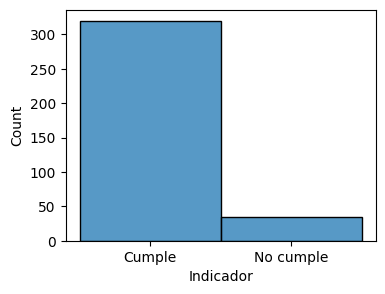

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (4,3))
sns.histplot(data = df, x = "Indicador", bins = 50)
plt.show()

In [34]:
# Contar el número de soportes que cumplen
soportes_cumplen = (df["Indicador"] == "Cumple").sum()

# Obtener el total de soportes recibidos
total_soportes = len(df)

indicador_final = (soportes_cumplen / total_soportes) * 100
print(f"Indicador mensual es: {indicador_final:.2f}%")

Indicador mensual es: 90.40%


In [36]:
!pip install tkcalendar

In [57]:
import tkinter as tk
from tkcalendar import Calendar
import datetime
import pandas as pd

# Función para obtener la fecha seleccionada
def obtener_fechas():
    # Obtiene las fechas seleccionadas
    fecha_inicio = calendar_inicio.get_date()
    fecha_fin = calendar_fin.get_date()
    
    # Convertir las fechas a formato adecuado
    fecha_inicio = str(fecha_inicio)
    fecha_fin = str(fecha_fin)
    
    # Crear la consulta SQL con las fechas seleccionadas
    query = f"""
    SELECT os.number AS No, 
           osd.priority,        
           DATE_ADD(os.created, INTERVAL -6 HOUR) as Creado,
           DATE_ADD(os.closed, INTERVAL -6 HOUR) as Cerrado
    FROM ost_ticket AS os
    LEFT JOIN ost_ticket__cdata AS osd ON os.ticket_id = osd.ticket_id
    LEFT JOIN ost_sla AS sla ON os.sla_id = sla.id
    WHERE os.topic_id BETWEEN 1 AND 26
    AND DATE_ADD(os.created, INTERVAL -6 HOUR) BETWEEN '{fecha_inicio}' AND '{fecha_fin}'
    ORDER BY os.created
    """
    
    # Imprimir la consulta para verificar
    print(query)
    
    # Aquí deberías ejecutar la consulta y obtener el resultado en tu dataframe (df)
    # df = pd.read_sql(query, engine)
    # return df

ventana.destroy()

# Crear la ventana principal
ventana = tk.Tk()
ventana.title("Seleccionar Fechas")

# Etiquetas
tk.Label(ventana, text="Fecha Inicial").grid(row=0, column=0, padx=10, pady=10)
tk.Label(ventana, text="Fecha Final").grid(row=1, column=0, padx=10, pady=10)

# Crear calendario para la fecha de inicio
calendar_inicio = Calendar(ventana, date_pattern='yyyy-mm-dd', locale="es_ES",
                          background = "blue",
                          foreground = "white",
                          selectbackground = "red",
                          normalbackground = "lightblue",
                          weekendbackground = "darkblue",
                          weekendforeground = "white")                          
calendar_inicio.grid(row=0, column=1, padx=10, pady=10)

# Crear calendario para la fecha de fin
calendar_fin = Calendar(ventana, date_pattern='yyyy-mm-dd', locale="es_ES",
                          background = "blue",
                          foreground = "white",
                          selectbackground = "red",
                          normalbackground = "lightblue",
                          weekendbackground = "darkblue",
                          weekendforeground = "white")                          
calendar_fin.grid(row=1, column=1, padx=10, pady=10)

# Botón para obtener las fechas y ejecutar la consulta
boton = tk.Button(ventana, text="Obtener resultados", command=obtener_fechas)
boton.grid(row=2, column=0, columnspan=2, pady=20)


# Iniciar la interfaz
ventana.mainloop()


TclError: can't invoke "destroy" command: application has been destroyed

In [58]:
import tkinter as tk
from tkcalendar import Calendar
import datetime
import pandas as pd

# Función para obtener la fecha seleccionada y cerrar la ventana
def obtener_fechas():
    # Obtiene las fechas seleccionadas
    fecha_inicio = calendar_inicio.get_date()
    fecha_fin = calendar_fin.get_date()
    
    # Convertir las fechas a formato adecuado
    fecha_inicio = str(fecha_inicio)
    fecha_fin = str(fecha_fin)
    
    # Crear la consulta SQL con las fechas seleccionadas
    query = f"""
    SELECT os.number AS No, 
           osd.priority,        
           DATE_ADD(os.created, INTERVAL -6 HOUR) as Creado,
           DATE_ADD(os.closed, INTERVAL -6 HOUR) as Cerrado
    FROM ost_ticket AS os
    LEFT JOIN ost_ticket__cdata AS osd ON os.ticket_id = osd.ticket_id
    LEFT JOIN ost_sla AS sla ON os.sla_id = sla.id
    WHERE os.topic_id BETWEEN 1 AND 26
    AND DATE_ADD(os.created, INTERVAL -6 HOUR) BETWEEN '{fecha_inicio}' AND '{fecha_fin}'
    ORDER BY os.created
    """
    
    # Imprimir la consulta para verificar
    print(query)
    
    # Aquí deberías ejecutar la consulta y obtener el resultado en tu dataframe (df)
    # df = pd.read_sql(query, engine)
    # return df
    
    # Cerrar la ventana de calendario
    ventana.destroy()

# Crear la ventana principal
ventana = tk.Tk()
ventana.title("Seleccionar Fechas")

# Etiquetas
tk.Label(ventana, text="Fecha de inicio").grid(row=0, column=0, padx=10, pady=10)
tk.Label(ventana, text="Fecha de fin").grid(row=1, column=0, padx=10, pady=10)

# Crear calendario para la fecha de inicio en español
calendar_inicio = Calendar(ventana, date_pattern='yyyy-mm-dd', locale='es_ES')
calendar_inicio.grid(row=0, column=1, padx=10, pady=10)

# Crear calendario para la fecha de fin en español
calendar_fin = Calendar(ventana, date_pattern='yyyy-mm-dd', locale='es_ES')
calendar_fin.grid(row=1, column=1, padx=10, pady=10)

# Botón para obtener las fechas y ejecutar la consulta
boton = tk.Button(ventana, text="Obtener resultados", command=obtener_fechas)
boton.grid(row=2, column=0, columnspan=2, pady=20)

# Iniciar la interfaz
ventana.mainloop()



    SELECT os.number AS No, 
           osd.priority,        
           DATE_ADD(os.created, INTERVAL -6 HOUR) as Creado,
           DATE_ADD(os.closed, INTERVAL -6 HOUR) as Cerrado
    FROM ost_ticket AS os
    LEFT JOIN ost_ticket__cdata AS osd ON os.ticket_id = osd.ticket_id
    LEFT JOIN ost_sla AS sla ON os.sla_id = sla.id
    WHERE os.topic_id BETWEEN 1 AND 26
    AND DATE_ADD(os.created, INTERVAL -6 HOUR) BETWEEN '2024-11-01' AND '2024-11-29'
    ORDER BY os.created
    
